In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import os
import pickle
import scipy.sparse as sp

functions_dir_path = './Functions/'
sys.path.append(functions_dir_path)

# from Spikes_SBM_fun import load_spikes
from functions import *

In [10]:
# define parameters

width = 3                  # width of culture 
height = 3                 # height of culture 
PDMS = 'Flat'            # type of pdms support: 'Tracks', 'Flat'
DYNAMICS = 'RS'            # neuron dynamics (Izhikevich)

l = 0.1                    # average axon length (mm)
rho = 250                   # neuron density (Neurons / mm^2) 

EI_ratio = 0.8             # Excitatory neurons proportion

# time of simulation
T = 20e3

# noise of Izhikevich params
no = 0.05           


In [11]:
"""
types of neurons in the culture and their percentage. 
the sum of excitatory (exc) and inhibitory (inh) must be 100 (separately)  
"""
neuron_types = {
    'ALL': {
        'exc': {'RS': 75, 'IB': 10, 'CH': 5, 'TC': 5, 'RZ': 5},
        'inh': {'FS': 80, 'LTS': 20}
    },
    'RS': {
        'exc': {'RS': 100, 'IB': 0, 'CH': 0, 'TC': 0, 'RZ': 0},
        'inh': {'FS': 0, 'LTS': 0}
    },
    'IB': {
        'exc': {'RS': 0, 'IB': 100, 'CH': 0, 'TC': 0, 'RZ': 0},
        'inh': {'FS': 0, 'LTS': 0}
    },
    'CH': {
        'exc': {'RS': 0, 'IB': 0, 'CH': 100, 'TC': 0, 'RZ': 0},
        'inh': {'FS': 0, 'LTS': 0}
    },
    'FS': {
        'exc': {'RS': 0, 'IB': 0, 'CH': 0, 'TC': 0, 'RZ': 0},
        'inh': {'FS': 100, 'LTS': 0}
    }
}

### run dynamics and plot results

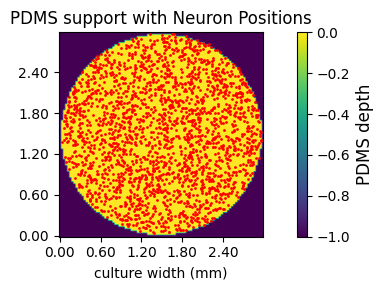

grow axons:


100%|█████████████████████████████████████████| 452/452 [00:32<00:00, 14.03it/s]


initial edges from grow_W: 75447/5062500
final edges (after removing = P_connect): 37910/5062500
run dynamics:


100%|███████████████████████████████████| 19999/19999 [00:14<00:00, 1379.88it/s]


done.
save results:
done. Files saved.


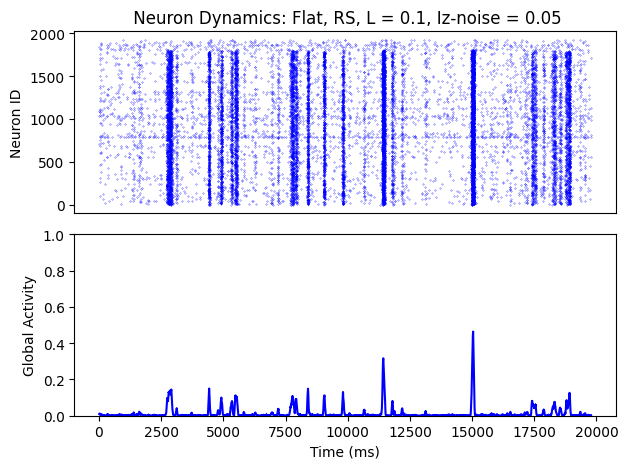

In [12]:
result_subdir = './RESULTS/'

# create PDMS support 
H, tracks_dpt, h = create_pdms(PDMS = PDMS)
# Place neurons on plane:
X, Y = place_neurons(width, height, H=H, rho=rho)
# plot culture (petri dish + pdms + neuron positions)
plot_neurons_and_pdms(X, Y, H, width, height, h)

# Start simulations: 

# Grow axons
print('grow axons:')
W = grow_W(width, height, X, Y, H=H, L=l)  # adjacency matrix
print('initial edges from grow_W: %d/%d' % (np.count_nonzero(W), np.power(np.shape(W)[1], 2)))


# Initialise neurons:
neu_type_exc = neuron_types[DYNAMICS]['exc']
neu_type_inh = neuron_types[DYNAMICS]['inh']
nw = init_network(len(X), W, Tn=T, neu_type_exc=neu_type_exc, neu_type_inh=neu_type_inh, noise_param=no, EI_ratio=EI_ratio)
print('final edges (after removing = P_connect): %d/%d' % (np.count_nonzero(nw['W']), np.power(nw['N'], 2)))

# Run dynamics:
print('run dynamics:')
run_nw(nw)
print('done.')

# Save dictionary and spikes list
print('save results:')
# Create folder
if not os.path.exists(result_subdir):
    os.makedirs(result_subdir)

# Save nw dict 
nw_path = os.path.join(result_subdir, f"{PDMS}_{DYNAMICS}_L_{l}_data.pkl")
with open(nw_path, 'wb') as file:
    pickle.dump(nw, file)

# Save rois with labels
rois_path = os.path.join(result_subdir, f"{PDMS}_{DYNAMICS}_L_{l}_rois.txt")

partition_list_type = nw['EI_partitions']['E_partition'] + nw['EI_partitions']['I_partition']
neu_type_labels = ['RS', 'IB', 'CH', 'TC', 'RZ', 'LTS', 'FS']  # Corresponding labels
labels_type_list = [label for count, label in zip(partition_list_type, neu_type_labels) for _ in range(count)]

partition_list_EI = [nw['Ne']] + [nw['Ni']]
neu_EI_labels = ['Exc', 'Inh']
labels_EI_list = [label for count, label in zip(partition_list_EI, neu_EI_labels) for _ in range(count)]

with open(rois_path, "w") as file:
    file.write(f"ROI id,X,Y,E/I,type,a,b,v0,delta_u\n")  # Updated header
    for i in range(len(list(X))):
        item = list(zip(X, Y, labels_EI_list, labels_type_list))[i]
        file.write(f"{i}, {item[0]}, {item[1]}, {item[2]}, {item[3]}, {nw['params']['a'][i]}, {nw['params']['b'][i]}, {nw['params']['v0'][i]}, {nw['params']['delta_u'][i]}\n")  # Added parameters

# Save spikes
spikes_path = os.path.join(result_subdir, f"{PDMS}_{DYNAMICS}_L_{l}_spikes.txt")  # spk_s = [t / 1000 for t in nw['spike_T']] # convert time in seconds from ms   
with open(spikes_path, "w") as file:
    file.write(f"ROI id, time (ms)\n")
    for item in zip(nw['spike_Y'], nw['spike_T']):
        file.write(f"{item[0]}, {item[1]}\n")


# Save txt file with some parameters
param_filename = f"{PDMS}_{DYNAMICS}_L_{l}_param.txt"
file_path = os.path.join(result_subdir, param_filename)
with open(file_path, 'w') as f:
    # Write parameter values to the file
    f.write('Parameter Values:\n')
    f.write(f'PDMS: {PDMS}\n')
    f.write(f'neuron dynamics (Izhikevich): {DYNAMICS}\n')
    f.write(f'width: {width} mm\n')
    f.write(f'height: {height} mm\n')
    f.write(f'axon length: {l} mm\n')
    f.write(f'neuron density: {rho} n/mm^2\n')
    f.write(f'noise driving: {nw["params"]["sigma"]}\n')
    f.write(f'noise Iz param: {nw["params"]["noise_param"]}\n')
    f.write(f'connection probability: {nw["params"]["P_connect"]}\n')
    f.write(f'PDMS barriers depth: {tracks_dpt}\n')
print('done. Files saved.')

# Scatter plot and global activity plot
matrix = create_firing_matrix(nw['spike_Y'], nw['spike_T'], nw['params']['Nt'], nw['N'])  # create raster plot matrix (dimension N*T)
matrix = matrix[:,200:]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
# scatter plot
neuron_ids, time_steps = np.nonzero(matrix)
ax1.scatter(time_steps, neuron_ids, marker='o', color='blue', s=0.05)
ax1.set_ylabel('Neuron ID')
ax1.set_title(f' Neuron Dynamics: {PDMS}, {DYNAMICS}, L = {l}, Iz-noise = {no}')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x ticks

# global activity plot
global_activity = []
step_size = 40
x_values = []

for i in range(0, len(matrix[0]) - step_size + 1):
    window_sum = np.sum(matrix[:, i:i + step_size], axis=1)
    active_neurons = np.count_nonzero(window_sum)
    window_activity = np.sum(active_neurons) / np.shape(matrix[:, 0])
    global_activity.append(window_activity)
    x_values.append(i + step_size // 2)  # Center of the window

# Plot
ax2.plot(x_values, global_activity, color='blue')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Global Activity')
ax2.set_ylim(0, 1)

plt.subplots_adjust(wspace=0)  # Remove space between subplots
plt.tight_layout()

plt.show()
